## Generate pseudo modality via CoMIR for multimodal image registration
The idea is to first convert the images of different modality into a common intermediate pseudo modality.  
The registration problem become monomodal and traditional registration algorithms such as SIFT matching can be used.
Details regarding the modal are presented in CoMIR [paper](https://arxiv.org/abs/2006.06325)

In [ ]:
import imagej
import torch
from skimage import img_as_float, util, exposure, img_as_uint, io
from glob import glob
import os
import shutil
import numpy as np
from tqdm import tqdm
from models.tiramisu import DenseUNet
from IPython.display import clear_output
import matplotlib.pyplot as plt

### Initialize PyImageJ
This can take a while for the first run.

In [ ]:
ij = imagej.init('sc.fiji:fiji', mode='headless')
print(f"ImageJ version: {ij.getVersion()}")

### Load a traiend CoMIR model
Model definition used in CoMIR. This is necessary in order to load the saved model. Code (as well as those in the folder 'models') are taken from CoMIR [repo](https://github.com/MIDA-group/CoMIR)

In [ ]:
class ModNet(DenseUNet):
    def __init__(self, **args):
        super(ModNet, self).__init__(**args, include_top=False)
        out_channels = self.get_channels_count()[-1]
        self.final_conv = torch.nn.Conv2d(out_channels, latent_channels, 1, bias=False)

    def forward(self, x):
        # Penultimate layer
        L_hat = super(ModNet, self).forward(x)
        # Final convolution
        return self.final_conv(L_hat)

In [ ]:
checkpoint = torch.load("CoMIR/models/model_L1_20221902_213529.pt") # Path to saved weights. This will be the models trained using CoMIR
device = "cuda:0" # Name of the device to run the the model. (Example for using GPU: cuda:0)

modelA = checkpoint['modelA']
modelB = checkpoint['modelB']
modelA.to(device)
modelB.to(device)
modelA.eval()
modelB.eval()

Parameters for patch extraction. The parameter `window_size` need to be the same as what is used in CoMIR training to ensure good performance.

In [ ]:
window_size = (256, 256) # Sliding window size
step_size = (192, 192) # Sliding window step
boundary = 16 # Remove pixels affected by boundary effect of DL model. The value should be smaller than (window_size-step_size)
modalA_files = glob('CoMIR/modalA/*') # Image files of modality A 
modalB_files = glob('CoMIR/modalB/*') # Image files of modality B
out_path = 'CoMIR/output' # Folder to save the converted output

### Show images of original modality

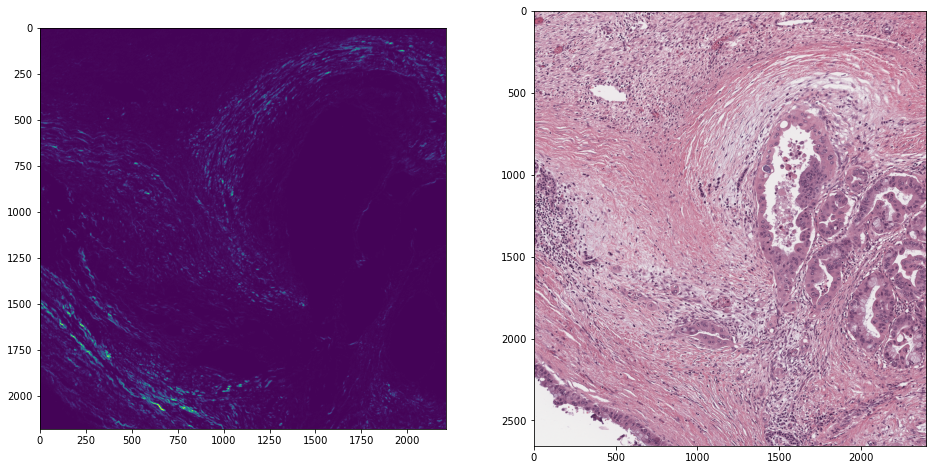

In [25]:
img_1 = io.imread(modalA_files[-1])
img_2 = io.imread(modalB_files[-1])
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img_1)
ax[1].imshow(img_2)

In [ ]:
def modalA_preproc(img):
    return exposure.rescale_intensity(img, in_range=(np.percentile(img, 10), np.percentile(img, 99.8)), out_range=(0, 1))

def modalB_preproc(img):
    return img

def pad_img(img, ch):
    if ch == 1:
        img = np.pad(img, ((0, 256), (0, 256)), mode='symmetric')
    elif ch == 3:
        img = np.pad(img, ((0, 256), (0, 256), (0, 0)), mode='symmetric')
    return img

The process involve patch extraction (using sliding window). Patch conversion, and patch stitching. The same procedure is used for both modalities.

In [23]:
os.makedirs(os.path.join(out_path, 'modalA'), exist_ok=True)
os.makedirs(os.path.join(out_path, 'modalB'), exist_ok=True)
for modalA_file, modalB_file in tqdm(zip(modalA_files, modalB_files), total=len(modalA_files)):
    modalA_name = os.path.basename(modalA_file)
    modalB_name = os.path.basename(modalB_file)
    im_modalA = modalA_preproc(img_as_float(io.imread(modalA_file)))
    im_modalB = modalB_preproc(img_as_float(io.imread(modalB_file)))
    shape_A = im_modalA.shape
    shape_B = im_modalB.shape
    modalA_chn = im_modalA.shape[-1] if len(im_modalA.shape) > 2 else 1
    modalB_chn = im_modalB.shape[-1] if len(im_modalB.shape) > 2 else 1
    pad_chn = lambda window, chn : list(window)+[chn] if chn > 1 else list(window)
    modalA_window_size = pad_chn(window_size, modalA_chn)
    modalB_window_size = pad_chn(window_size, modalB_chn)
    modalA_window_step = pad_chn(step_size, modalA_chn)
    modalB_window_step = pad_chn(step_size, modalB_chn)
    im_modalA = pad_img(im_modalA, modalA_chn)
    im_modalB = pad_img(im_modalB, modalB_chn)
    win_modalA = util.view_as_windows(im_modalA, modalA_window_size, modalA_window_step).squeeze() # generate sliding windows
    win_modalB = util.view_as_windows(im_modalB, modalB_window_size, modalB_window_step).squeeze()
    os.makedirs(os.path.join(out_path, 'temp', 'modalA'), exist_ok=True)
    os.makedirs(os.path.join(out_path, 'temp', 'modalB'), exist_ok=True)
    pad_dim = lambda img, chn : img.transpose(2, 0, 1)[None, :] if chn > 1 else img[None, None, :]
    ### Convert the patches into pseudo modality
    with torch.no_grad():
        for i in range(win_modalA.shape[0]):
            for j in range(win_modalA.shape[1]):
                tensor_modalA = torch.from_numpy(pad_dim(win_modalA[i, j], modalA_chn)).float().to(device)
                L1 = modelA(tensor_modalA)
                L1 = L1.cpu().detach().numpy()[0]
                io.imsave(os.path.join(out_path, 'temp', 'modalA', f'{i}_{j}.tiff'), L1[:, boundary:-boundary, boundary:-boundary].squeeze())
        for i in range(win_modalB.shape[0]):
            for j in range(win_modalB.shape[1]):
                tensor_modalB = torch.from_numpy(pad_dim(win_modalB[i, j], modalB_chn)).float().to(device)
                L2 = modelB(tensor_modalB)
                L2 = L2.cpu().detach().numpy()[0]
                io.imsave(os.path.join(out_path, 'temp', 'modalB', f'{i}_{j}.tiff'), L2[:, boundary:-boundary, boundary:-boundary].squeeze())

    ### Generate tile configuration file that contains the layerout of patches (coordinates). The file will be used as the input for stitching plugin
    with open(os.path.join(out_path, 'temp', 'modalA', 'TileConfiguration.txt'), 'w') as text_file:
        print('dim = {}'.format(2), file=text_file)
        for i in range (0, win_modalA.shape[1]):
            for j in range (0, win_modalA.shape[0]):
                print('{}_{}.tiff; ; ({}, {})'.format(j, i, i*modalA_window_step[0], j*modalA_window_step[1]), file=text_file)
    with open(os.path.join(out_path, 'temp', 'modalB', 'TileConfiguration.txt'), 'w') as text_file:
        print('dim = {}'.format(2), file=text_file)
        for i in range (0, win_modalB.shape[1]):
            for j in range (0, win_modalB.shape[0]):
                print('{}_{}.tiff; ; ({}, {})'.format(j, i, i*modalB_window_step[0], j*modalB_window_step[1]), file=text_file)

    ### Configure the pararmeters of the stitching pluginn
    os.makedirs(os.path.join(out_path, 'temp', 'stitched'), exist_ok=True)
    params = {'type': 'Positions from file', 'order': 'Defined by TileConfiguration', 
                'directory':os.path.join(out_path, 'temp', 'modalA'), 'ayout_file': 'TileConfiguration.txt', 
                'fusion_method': 'Linear Blending', 'regression_threshold': '0.30', 
                'max/avg_displacement_threshold':'2.50', 'absolute_displacement_threshold': '3.50', 
                'compute_overlap':False, 'computation_parameters': 'Save computation time (but use more RAM)', 
                'image_output': 'Write to disk', 'output_directory': os.path.join(out_path, 'temp', 'stitched')}
    ### Call the stitching plugin
    plugin = "Grid/Collection stitching"
    ij.py.run_plugin(plugin, params)
    stitched_modalA = io.imread(glob(os.path.join(out_path, 'temp', 'stitched', '*'))[0])[:shape_A[0], :shape_A[1]]
    io.imsave(os.path.join(out_path, 'modalA', modalA_name), img_as_uint(exposure.rescale_intensity(stitched_modalA, out_range=(0, 1)))) 
    shutil.rmtree(os.path.join(out_path, 'temp', 'stitched'))
    ### repeat the process for the other modality
    os.makedirs(os.path.join(out_path, 'temp', 'stitched'), exist_ok=True)
    params = {'type': 'Positions from file', 'order': 'Defined by TileConfiguration', 
                'directory':os.path.join(out_path, 'temp', 'modalB'), 'ayout_file': 'TileConfiguration.txt', 
                'fusion_method': 'Linear Blending', 'regression_threshold': '0.30', 
                'max/avg_displacement_threshold':'2.50', 'absolute_displacement_threshold': '3.50', 
                'compute_overlap':False, 'computation_parameters': 'Save computation time (but use more RAM)', 
                'image_output': 'Write to disk', 'output_directory': os.path.join(out_path, 'temp', 'stitched')}
    plugin = "Grid/Collection stitching"
    ij.py.run_plugin(plugin, params)  
    stitched_modalB = io.imread(glob(os.path.join(out_path, 'temp', 'stitched', '*'))[0])[:shape_B[0], :shape_B[1]]
    io.imsave(os.path.join(out_path, 'modalB', modalB_name), img_as_uint(exposure.rescale_intensity(stitched_modalB, out_range=(0, 1)))) 
    shutil.rmtree(os.path.join(out_path, 'temp'))
    clear_output(wait=True)

100%|██████████| 2/2 [06:44<00:00, 202.40s/it]


### Show converted images in pseudo modality

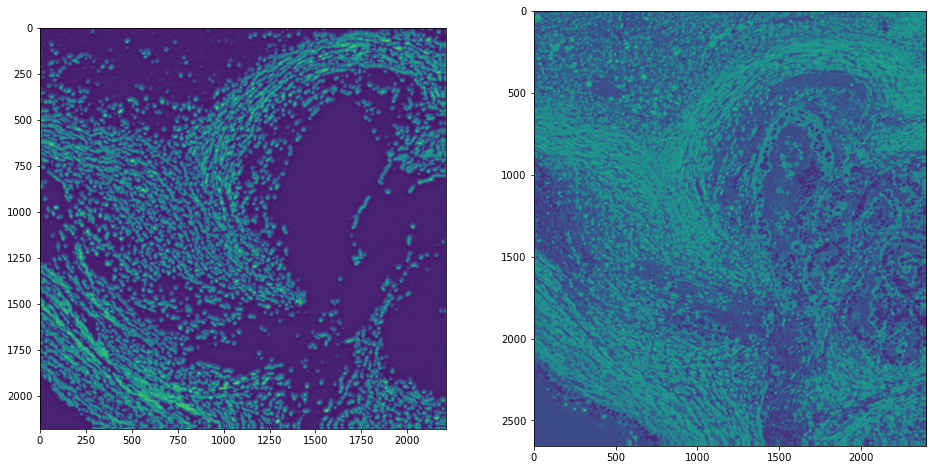

In [24]:
img_1 = io.imread(os.path.join(out_path, 'modalA', modalA_name))
img_2 = io.imread(os.path.join(out_path, 'modalB', modalB_name))
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img_1)
ax[1].imshow(img_2)